In [271]:
import numpy as np
import gensim
import nltk
from nltk.corpus import stopwords
import re
from sklearn.decomposition import PCA
from matplotlib import pyplot
import pickle

# Tasks 
(Python Solution to get an overview of the problem)
1. Extract the Embeddings of Documents & Query efficiently (In-/Out-Embeddings > 5GB each!)
2. Visualize the document-query embedding space
3. Compute DESM-Score and evaluate with experiment of Paper A Dual Embedding Space Model for Document Ranking (Table 2 in paper)

### Dependencies
1. word embeddings (in.txt, out.txt) need to be in same directory

# Extract Embeddings

In [272]:
#Show first Document of the input-data
open('../../data/data.txt').read().split('\n\n')[0]

'Cambridge'

In [273]:
# define punctuation
punct = './;:()&+?!,'
punct_tok = ['.', '..', '...', ',', ';', ':', '(', ')', '"', '\'', '[', ']',
                      '{', '}', '-', '–', '+', '*', '--', '\'\'', '``', '|', '%', '!', '?']

punct_sent_remove = '\''
punct_sent_space = '_/'

url_token = "http\S+"

encoding_errors = {"&amp;":'&', "&#39;":'\''}


# A big stopword list would reduce processing time (less word-vectors) but maybe remove semantic information
#stop_words = set(stopwords.words('english'))
stop_words = ["the", "a"]



def get_documents(path, data_format):
    if data_format is "custom":
        with open(path) as f:
            docs = f.read().split("#!newDoc!#")
        return docs        
    if data_format is "csv":
        pass
    if data_format is "files":
        pass
    if data_format is "list":
        return path


def preprocess_tokens(tokens):
    # Preprocess on token level
    tokens = [tok for tok in tokens if tok not in punct_tok]
    tokens = [re.sub('[{}]'.format(punct), '', tok) for tok in tokens]
    tokens = [tok for tok in tokens if len(tok) > 1 or tok is "i"] #or tok.isdigit()]
    tokens = [tok for tok in tokens if tok not in stop_words]
    # Should digits be removed?
    tokens = [tok for tok in tokens if not tok.isdigit()]

    return tokens


def preprocess_sentence(sentence):
    # Preprocess on sentence level
    for encoding in list(encoding_errors.keys()):
        sentence = sentence.replace(encoding, encoding_errors[encoding])
    sentence = re.sub('{}'.format(url_token), ' ', sentence)
    sentence = re.sub('[{}]'.format(punct_sent_remove), '', sentence)
    sentence = re.sub('[{}]'.format(punct_sent_space), ' ', sentence)

    tokens = preprocess_tokens(nltk.tokenize.word_tokenize(sentence))
    
    return tokens


# Get the document titles and their associated indices
def get_titles(path, data_format="custom"):
    titles = {}
    
    # extract documents from file(s)
    docs = get_documents(path, data_format)

    # Tokenize Document to get title
    for idx, doc in enumerate(docs):

        # Preprocessing on sentence level
        sentences = nltk.tokenize.sent_tokenize(doc)
        
        # Get title of document
        title = sentences[0].splitlines()
        title = [tok for tok in title if tok is not ""]
        titles[idx] = title[0]
        
    return titles


#Tokenize Documents (documents are seperated by "\n\n" and terminated by "\n\n\n")
def preprocess_docs(path, data_format="custom"):
    
    # extract documents from file(s)
    docs = get_documents(path, data_format)

    #Tokenize documents into sentences
    preprocessed_docs = []
    for idx, doc in enumerate(docs):
        # Preprocessing on document level
        doc = doc.lower()
        
        # Preprocessing on sentence level
        sentences = nltk.tokenize.sent_tokenize(doc)
        
        preprocessed_sentence = []
        for sent_idx, sent in enumerate(sentences):
            preprocessed_sentence += preprocess_sentence(sent)
        
        # Append preprocessed sentences to new list
        preprocessed_docs.append(preprocessed_sentence)

    return preprocessed_docs

In [274]:
#get a list of the tokenized documents
documents = preprocess_docs('../../data/data.txt')

In [275]:
doc_titles = get_titles("../../data/data.txt")

In [276]:
doc_titles

{0: 'Cambridge',
 1: 'Oxford',
 2: 'Giraffes',
 3: 'Giraffes_switched',
 4: 'Cambridge_switched'}

In [282]:
eval_docs  = preprocess_docs("../../data/corpus.txt")
eval_titles = get_titles("../../data/corpus.txt")

In [283]:
eval_titles

{0: 'KRDO.com - Lindsay Lohan trial set for next month - Entertainment - Home',
 1: 'High res in game screenshots of War Hero PvP armor (all 8 sets)',
 2: 'Blizzard read this: You MUST set up a Pro-Gamer liaison position NOW.',
 3: "Courant.com - CL&amp;P, Linemen's Union Reach Tentative Agreement - Courant.com",
 4: 'Colvin will return for his senior season - The Norman Transcript - Sports',
 5: 'Why is set theory a joke"?"',
 6: "France set for Mali 'direct combat' - World news, News - Belfasttelegraph.co.uk",
 7: 'Ok, we need to talk about this Alpine Ursa set',
 8: 'The-Daily-Record.com - Symptom free, Crosby ready to return to NHL elite - The Daily Record',
 9: "Some guy downloaded one of my mixes and played a 'live' set at some party consisting entirely of my mix and a couple loops over the top.",
 10: "Click On Detroit - Charges come in Chilean singer's 1973 death - News - Home - Author - By Mariano Castillo CNN",
 11: 'News anchor keeps his cool during powerful earthquake - WTV

In [107]:
#build an offset index for each word in the embedding-file to later access the correct word-embedding using seek()
def build_embed_index(path):
    f = open(path)
    d = dict()
    offset = 0
    for idx, word in enumerate(f):
        if idx%1000000==0:
            print('Progress: Line ' + str(idx))
        d[word.split('\t')[0]] = offset
        offset += len(word)+1
    f.close()
    return d

In [108]:
in_modelfile = '../../model/in.txt'
out_modelfile = '../../model/out.txt'
#dt = np.dtype("U, (200,)f8")

In [109]:
#Build index for in & out word-embeddings
#in_dic = build_embed_index(in_modelfile)
#out_dic = build_embed_index(out_modelfile)

In [110]:
#save model indices for quick access (without loading model into memory)
"""
with open('/home/phil/Schreibtisch/Uni/MA/Forschungsprojekt/in_index.obj', 'wb') as f:
    pickle.dump(in_dic, f)

with open('/home/phil/Schreibtisch/Uni/MA/Forschungsprojekt/out_index.obj', 'wb') as f:
    pickle.dump(out_dic, f)
"""

# load model indices
with open('../../model/in_index.obj', 'rb') as f:
    in_dic = pickle.load(f)

with open('../../model/out_index.obj', 'rb') as f:
    out_dic = pickle.load(f)

In [111]:
break_int = 0
with open(in_modelfile, 'r') as modelfile:
    with open("model_new_tst", 'w') as newmodel:
        newmodel.write("101 200\n")
        for line in modelfile:
            break_int += 1
            newmodel.write(line)
            if break_int == 100:
                break

In [112]:
#model = gensim.models.Word2Vec()
#model = gensim.models.KeyedVectors.load_word2vec_format("model_new_tst", binary=False, datatype=np.float64)

In [113]:
#As an example: Show the in-word-embedding for the word "the"
f = open('../../model/in.txt')
f.seek(0)
f.seek(in_dic['cambridge'])
w = f.readline()
print(w.split('\t')[0], [float(i) for i in w.split('\t')[1:]])
f.close()

cambridge [0.04458, -0.008986, -0.060948, -0.017803, 0.043617, 0.059742, 0.016003, 0.047541, 0.020506, 0.050478, -0.025849, -0.01772, -0.049592, -0.010154, 0.060938, 0.145544, -0.05914, 0.046458, -0.057872, 0.063647, -0.040152, 0.019553, 0.072412, 0.016585, -0.06485, 0.07392, -0.023465, 0.10323, 0.033276, 0.046891, -0.06604, 0.089709, -0.013042, 0.023901, -0.088856, -0.116092, -0.051974, 0.028408, -0.042594, -0.066716, -0.083513, 0.021399, 0.054435, -0.057351, -0.04807, 0.09534, 0.054126, -0.042042, -0.006303, -0.021994, 0.102618, 0.121487, -0.032814, -0.066175, 0.071879, 0.050986, 0.015519, 0.101778, -0.017493, -0.0082, 0.11973, -0.006143, -0.134806, -0.030183, -0.099897, -0.054662, 0.030468, 0.053002, 0.052606, -0.003097, -0.079577, 0.055978, 0.034838, 0.036461, -0.056506, 0.001546, 0.023694, -0.061339, -0.030392, 0.028833, 0.044646, 0.044805, 0.035043, 0.089791, -0.041356, -0.034887, 0.022974, -0.025776, 0.011678, -0.048851, 0.050003, 0.075171, -0.077506, 0.061281, 0.018234, 0.03492

In [138]:
#extract the word-vectors for each word in a document, yielding a list of word-vectors instead of the word itself per document
def extract_embed(file, dic, doc):
    fd = open(file)
    vecs = []
    for word in doc:
        if word not in dic.keys():
            continue
            #vecs.append(np.zeros(200))
        else:
            fd.seek(dic[word])
            w = fd.readline()
            vecs.append(np.array([float(i) for i in w.split('\t')[1:]]))
    fd.close()
    return vecs

In [139]:
#Get word embeddings for each document, yielding the Data Structure: doc_embeds[doc][vec][item]
doc_embeds = []
for document in documents:
    doc_embeds.append(extract_embed('../../model/out.txt', out_dic, document))
#To test the result, print the length of the first word vector of the first document (each vector should have 200 entries)
len(doc_embeds[0][0])

200

In [140]:
#Get word embeddings for the query, resulting Data Structure: query_embeds[query][vec][item]
query = 'cambridge city'

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
q_tokens = tokenizer.tokenize(query)

query_embeds = []
query_embeds.append(extract_embed('../../model/in.txt', in_dic, q_tokens))
#To test the result, print the length of the first word vector of the first query (each vector should have 200 entries)
len(query_embeds[0][0])

200

In [141]:
len(query_embeds[0][0])

200

In [142]:
#Using gensim to load the word embeddings doesn't seem to work because of formating (also the files are really big)
# =>correct formating is another approach to try!
#wordvecs = gensim.models.KeyedVectors.load_word2vec_format('in.txt', binary=False)

# Visualize document-query embedding space

## How to represent a Document D with word embeddings
Here D is the centroid of all the normalized vectors for the words in the document serving as a single embedding for the whole document

## How to compute a centroid of word embeddings
To find the centroid, one computes the (arithmetic) mean of the points' positions separately for each dimension.

## Computing a Documents-Query Representation with PCA
A  two  dimensional  PCA  projection  of  the  200-
dimensional embeddings. Relevant documents are yellow, irrel-
evant documents are grey, and the query is blue.  To visualize
the  results  of  multiple  queries  at  once,  before  dimensionality
reduction we centre query vectors at the origin and represent
documents as the difference between the document vector and
its query vector.

In [143]:
#Compute Document-Centroid

#A function to compute the euclidean norm of a vector
def euclid_norm(v):
    norm = 0
    for i in v:
        norm += i**2
    return np.sqrt(norm)

#A function to compute the absolute/manhattan norm of a vector
def abs_norm(v):
    norm = 0
    for i in v:
        norm += abs(i)
    return norm

#Compute the centroid of the word-vectors of a Document to get a Document-Vector
def compute_centroid(D):
    D_N = len(D)
    centroid = np.zeros(len(D[0]))
    for d in D:
        centroid += d / euclid_norm(d)
    return centroid/D_N

In [144]:
#Compute the document vectors by computing the centroid of the word-vectors of the document, yielding the data structure: doc_centroids[doc][entry]
doc_centroids = []
for embed in doc_embeds:
    doc_centroids.append(compute_centroid(embed))
#To test the result, print the length of the first document vector (each vector should have 200 entries)
len(doc_centroids[0])

200

In [145]:
import copy
docs_query = copy.deepcopy(doc_centroids)
for i in query_embeds[0]:
    docs_query.append(i)
len(docs_query)

7

In [146]:
#Create a PCA-Object to project the 200-dim. Document-Vector into a 2-dim. Vector
pca = PCA(n_components=2)
doc_pca = pca.fit_transform(docs_query)

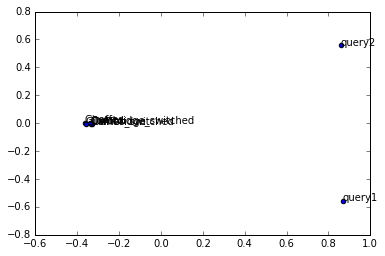

In [147]:
#Now we can visualize the Documents in a 2-dim. Space, for human interpretability
pyplot.scatter(list(doc_pca[:, 0]), list(doc_pca[:, 1]))
doc_title = ['Cambridge', 'Oxford', 'Giraffes', 'Giraffes_switched', 'Cambridge_switched', 'query1', 'query2']
for idx, doc in enumerate(doc_title):
    pyplot.annotate(doc, xy=(doc_pca[idx,0], doc_pca[idx,1]))
pyplot.show()

## Compute DESM

In [148]:
#Function to compute DESM-Measure for a query and all documents (see paper for the DESM-formula)
def desm(Q, D):
    #Denominator
    Q_N = len(Q)
    #Sum of cosine similarities between query term and document
    Q_cosine = 0
    for q in Q:
        Q_cosine += q.dot(D) / euclid_norm(q) * euclid_norm(D)
    return Q_cosine/Q_N

In [149]:
#Helper-Function for the sorting of the DESM-Scores
def sort_help(elem):
    return elem[1]

#Create list of tuples for each Document-Title & the DESM-Score of the Query & the Document
ranking = [(doc_title[idx], desm(query_embeds[0], doc_centroids[idx])) for idx in range(len(doc_centroids))]

#Sort the DESM-Score, to show the most relevant document on top of the list
ranking.sort(key=sort_help, reverse=True)
ranking

[('Cambridge', -0.04539069919658721),
 ('Oxford', -0.048019800252019296),
 ('Cambridge_switched', -0.052278710660321207),
 ('Giraffes_switched', -0.07195392766674968),
 ('Giraffes', -0.07591455167841867)]

We see that for the query "cambridge" the document about cambridge is the most relevant.
This is followed by the document about oxford, which is also an article about a univerity.
More interestingly, the article about cambridge, where the word "cambridge" was substituted by the word "giraffe" is next relevant even though it doesn't contains the word cambridge, while the document about giraffes where the word "giraffe" is substituded by the word "cambridge" has a much worse score. This makes sense because the document is about giraffes and not about cambridge. Hence word-stuffing-trick has way less impact on the DESM-ranking then it would have on a TFIDF-Ranking (because it would count the word cambridge which would give it much more relevance).
As expected, the document about Giraffes has the least relevance in the ranking.